This notebook is part of the project "GestoTune - Gesture recognition for Tune control" made for the exam of Intelligent Consumer Technologies by Priscilla Cortese and Alessandro Piani


#Hand Gesture Recognition Model
In this noteboook we're going to go through the process of creating the custom dataset and model for the main task of our project: hand gesture recognition.

The dataset is obtained starting from the subsample of the [HaGRID dataset](https://www.kaggle.com/datasets/kapitanov/hagrid/data), and it is adapted to our task (gestures to controll music).

We decided to exploit MediaPipe's [Hand landmark detection](https://developers.google.com/mediapipe/solutions/vision/hand_landmarker) model to get landmarks of the hands, to then process them through a NN classifier.

## Prepare the dataset

### Select gestures


In [ ]:
# Load subsample of HaGRID [100 photos for gesture]
%%capture
!wget https://n-usr-2uzac.s3pd12.sbercloud.ru/b-usr-2uzac-mv4/hagrid/subsample.zip
!unzip subsample.zip

The dataset for gesture recognition in model maker requires the following format: `<dataset_path>/<label_name>/<img_name>.*`. In addition, one of the label names (`label_names`) must be `none`. The `none` label represents any gesture that isn't classified as one of the other gestures.

Since our first idea was to use MediaPipe's model maker, we followed such indications to organize our data.

In our project we decided to use the following gestures:
* Fist: closed fist, palm forward, which will be used to play the music
* Stop: open palm with close fingers, to stop the music
* Like: thumbs up, which will be used to increase the volume
* Dislike: thumbs down, which will be used to lower the volume
* Two up: palm forward, to skip to previous song
* Two down: back of the hand forward, to skip to next song

The last class was created by rotating of 180° the images of people showing two fingers with the back of the hand forward (`two_up_inverted` class). This makes the gesture valid because gestures will be classified based on landmarks, which are independent of the posture/position of the person.

In the following code the class "peace" is also extracted, because of an initial idea of use, but won't be considered.



In [ ]:
import os
import random
from PIL import Image
import shutil

#Let's re-organize the folders
folders_to_move = ["dislike", "fist", "like", "peace", "stop", "two_up"]
folders_to_rotate = ["two_up_inverted"]

# Create a folder named "samples" if it doesn't exist already
samples_folder_path = "/content/samples"
if not os.path.exists(samples_folder_path):
  os.makedirs(samples_folder_path)

# Move the folders of the gestures we need
for folder in folders_to_move:
  src = os.path.join("/content", folder)
  dst = os.path.join(samples_folder_path, folder)
  shutil.move(src, dst)

In [ ]:
# create new folders for two fingers pointing down
two_down_path = "/content/two_down"
if not os.path.exists(two_down_path):
  os.makedirs(two_down_path)


In [ ]:
def rotate_and_save(src_img_path, src_img_list, dst_path, angle):
  for file_name in src_img_list:
    img = Image.open(os.path.join(src_img_path, file_name))
    rotated_img = img.rotate(angle)
    rotated_img.save(os.path.join(dst_path, file_name))

In [ ]:
for input_folder in folders_to_rotate:
  input_folder_path = os.path.join("/content", input_folder)
  files = os.listdir(input_folder)
  rotate_and_save(input_folder_path, files, two_down_path, 180)

In [ ]:
# let's move two down folder in samples as well
shutil.move(two_down_path, "/content/samples/two_down")

'/content/samples/two_down'

Let's create a null class, following the suggestion of media pipe. This class consist of random gestures, and is done simply by picking a few photos from the folders that haven't been used.

In [ ]:
# Define the paths to the folders
source_folders = ["call", "four", "mute", "ok", "one", "rock", "three"] #un-used folders
null_class_folder = "/content/samples/None"

# Create the null class folder if it doesn't exist
if not os.path.exists(null_class_folder):
  os.makedirs(null_class_folder)

num = 100 // len(source_folders) # 100 is the size of all the other folders

# Select images from each folder
for folder in source_folders:
  folder_path = os.path.join("/content", folder)
  images = os.listdir(folder_path)

  # Randomly shuffle the images
  random.shuffle(images)

  # Select the desired number of images
  selected_images = images[:num]

  # Move the selected images to the null class folder
  for image in selected_images:
    src = os.path.join(folder_path, image)
    dst = os.path.join(null_class_folder, image)
    shutil.move(src, dst)


Let's verify the data structure and plot some images



In [ ]:
print(samples_folder_path)
labels = []
for i in os.listdir(samples_folder_path):
  if os.path.isdir(os.path.join(samples_folder_path, i)):
    labels.append(i)
print(labels)

/content/samples
['two_up', 'fist', 'two_down', 'stop', 'None', 'dislike', 'like', 'peace']


In the our newly created dataset, some files of type `.ipynb_checkpoints`: these are not useful for our scope so in the following block we remove them.
Lastly, we zip the folder to avoid re-doing the above procedure when employing the dataset.

In [ ]:
import os
# Recursively traverse the folder structure
for root, dirs, files in os.walk('/content/samples'):
  # Check if any directory in the current root contains ".ipynb_checkpoints"
  for dir_name in dirs:
    if ".ipynb_checkpoints" in dir_name:
      # Construct the full path to the directory
      dir_path = os.path.join(root, dir_name)

      # Remove all files inside the directory
      for file_name in os.listdir(dir_path):
        file_path = os.path.join(dir_path, file_name)
        try:
          if os.path.isfile(file_path):
              os.remove(file_path)
        except Exception as e:
          print(f"Error while removing file: {e}")
      # Now remove the directory itself
      try:
        os.rmdir(dir_path)
      except Exception as e:
        print(f"Error while removing directory: {e}")

In [ ]:
# Zip the folder
folder_to_zip = "/content/samples"
zip_file_path = "/content/samples.zip"
shutil.make_archive(folder_to_zip, 'zip', folder_to_zip)

# Copy the zip file to Google Drive
drive_folder = "/content/drive/My Drive/ColabData"
shutil.copy(zip_file_path, drive_folder)

'/content/drive/My Drive/ColabData/samples.zip'

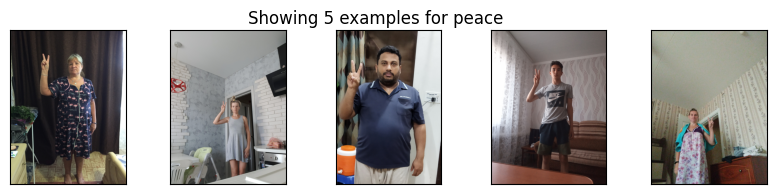

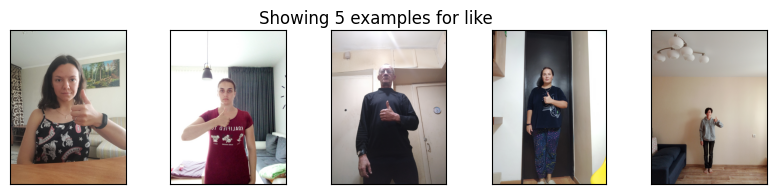

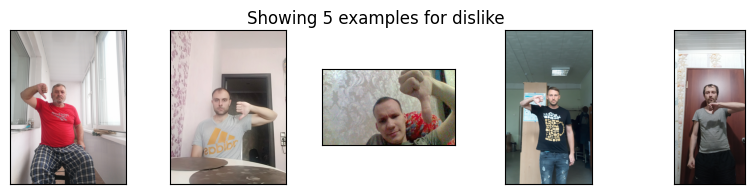

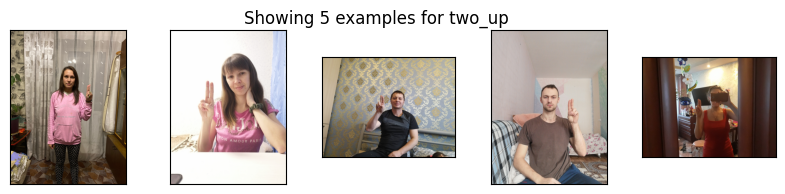

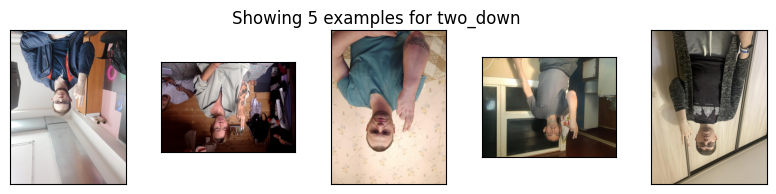

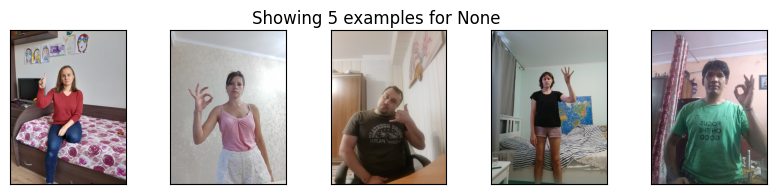

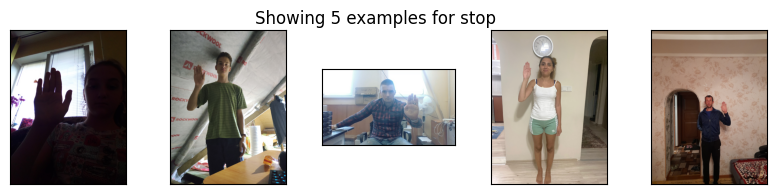

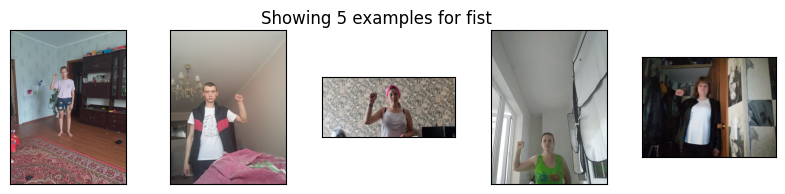

In [ ]:
import matplotlib.pyplot as plt

NUM_EXAMPLES = 5

for label in labels:
  label_dir = os.path.join(samples_folder_path, label)
  example_filenames = os.listdir(label_dir)[:NUM_EXAMPLES]
  fig, axs = plt.subplots(1, NUM_EXAMPLES, figsize=(10,2))
  for i in range(NUM_EXAMPLES):
    axs[i].imshow(plt.imread(os.path.join(label_dir, example_filenames[i])))
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
  fig.suptitle(f'Showing {NUM_EXAMPLES} examples for {label}')

plt.show()

###Extract hand landmarks

The dataset, as prepared in the above section, can be used for example to fine tune MediaPipe's hand gesture recognition model using `model maker`.

Here we wanted to take a step forward and extract the landmarks from all the pictures of our new dataset, and process these through a custom classifier. This allows more flexibility and gives more insight on how data is flowing throught the model, as well as a more detailed evaluation of the former.

Let's start by loading the annotations of HaGRID's subsample and the above created dataset.

In [ ]:
import zipfile
zip_file_path = '/content/drive/MyDrive/ColabData/samples_def.zip'
destination_path = '/content/samples/'

# Create the destination directory if it doesn't exist
os.makedirs(destination_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_path)

os.listdir(destination_path)

['two_up', 'fist', 'dislike', 'peace', 'None', 'stop', 'two_down', 'like']

In [ ]:
!wget https://n-usr-2uzac.s3pd12.sbercloud.ru/b-usr-2uzac-mv4/hagrid/ann_subsample.zip

--2024-02-16 08:17:03--  https://n-usr-2uzac.s3pd12.sbercloud.ru/b-usr-2uzac-mv4/hagrid/ann_subsample.zip
Resolving n-usr-2uzac.s3pd12.sbercloud.ru (n-usr-2uzac.s3pd12.sbercloud.ru)... 37.230.193.192
Connecting to n-usr-2uzac.s3pd12.sbercloud.ru (n-usr-2uzac.s3pd12.sbercloud.ru)|37.230.193.192|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1297620 (1.2M) [application/zip]
Saving to: ‘ann_subsample.zip’

ann_subsample.zip   100%[===================>]   1.24M  1.41MB/s    in 0.9s    

2024-02-16 08:17:05 (1.41 MB/s) - ‘ann_subsample.zip’ saved [1297620/1297620]



In [ ]:
!unzip ann_subsample.zip

Archive:  ann_subsample.zip
   creating: ann_subsample/
  inflating: __MACOSX/._ann_subsample  
  inflating: ann_subsample/mute.json  
  inflating: __MACOSX/ann_subsample/._mute.json  
  inflating: ann_subsample/ok.json   
  inflating: __MACOSX/ann_subsample/._ok.json  
  inflating: ann_subsample/peace_inverted.json  
  inflating: __MACOSX/ann_subsample/._peace_inverted.json  
  inflating: ann_subsample/three2.json  
  inflating: __MACOSX/ann_subsample/._three2.json  
  inflating: ann_subsample/three.json  
  inflating: __MACOSX/ann_subsample/._three.json  
  inflating: ann_subsample/rock.json  
  inflating: __MACOSX/ann_subsample/._rock.json  
  inflating: ann_subsample/one.json  
  inflating: __MACOSX/ann_subsample/._one.json  
  inflating: ann_subsample/like.json  
  inflating: __MACOSX/ann_subsample/._like.json  
  inflating: ann_subsample/call.json  
  inflating: __MACOSX/ann_subsample/._call.json  
  inflating: ann_subsample/stop_inverted.json  
  inflating: __MACOSX/ann_subsampl

In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 47.0 MB/s eta 0:00:00


In [ ]:
import os
import json
import cv2
import numpy as np
import mediapipe as mp
from sklearn.model_selection import train_test_split

# initialize mediapipe hands -> used x landmark extraction
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils


In the following blocks we extract hand landmarks from our dataset. In doing so, we encountered a couple of problems and fixed them in the following ways:
* Some gestures were performed with the right hand, some with the left: this is solved by using the `leading_hand` label in the annotations. All photos marked with `right` are going to be flipped: in this way we will have only pictures in which people use the right hand (note that the webcam flips the images)
* In some images, hands are not detected: this can be due to multiple reasons, from unfortunate lighting to people posing too far from the camera. Such photos are excluded from the "final" landmark dataset as they wouldn't provide any useful information during training.

In [ ]:
# To have all data regarding 1! hand
def flip_if_right_hand(image, gesture, image_name):
  # Get annotation corresponding to the considered gesture
  json_path = f'/content/ann_subsample/{gesture}.json'
  with open(json_path) as f:
    data = json.load(f)
  if data[image_name]['leading_hand'] == 'right':
    # Flip hand along the y-axis
    return cv2.flip(image, 1)
  return image

This function extracts landmarks from the images, using `hands`. For each image this will return, in case an hand is detected, 21 landmarks each with 3 coordinates.

In [ ]:
def extract_landmarks(image):
  # convert the BGR image (standard cv2) to RGB (standard for hands) + process it
  results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  if results.multi_hand_landmarks: # go ahead only if an hand is detected
    # extract landmarks
    landmarks = []
    for landmark in results.multi_hand_landmarks[0].landmark:
      landmarks.append([landmark.x, landmark.y, landmark.z])
    return np.array(landmarks)
    # return empty list if no hand is detected
  return []

In [ ]:
base_path = '/content/samples'
gestures = os.listdir(base_path)
all_landmarks = []
labels = []

for gesture in gestures:
  gesture_path = os.path.join(base_path, gesture)
  for image_name in os.listdir(gesture_path):
    image_path = os.path.join(gesture_path, image_name)
    image = cv2.imread(image_path)
    # 'None' class has a mix of gestures that are not of interest for our problem -> we don't have annotations x leading hands
    if gesture != 'None':
      image = flip_if_right_hand(image, gesture, image_name.split('.')[0])
    single_landmarks = extract_landmarks(image)
    # save only if an hand is actually detected, i.e. if the array is not empty
    if np.array(single_landmarks).size != 0:
      all_landmarks.append(single_landmarks)
      labels.append(gesture)

In [ ]:
# Convert result in numpy arrays
lmarks, labels = np.array(all_landmarks), np.array(labels)

In [ ]:
# Save landmarks and labels for future use
landmarks_path = '/content/drive/My Drive/ColabData/landmarks_oh.npy'
np.save(landmarks_path, lmarks)
labels_path = '/content/drive/My Drive/ColabData/labels_roh.npy'
np.save(labels_path, labels)

Here we check how many gestures we have for each class. Before this section we had 100 gestures for each class other than `None`, which had 98 gestures. The decrease of, on average, 14 gestures for each class is due to the fact that samples without any hands detected were discared.

In [ ]:
for gest in gestures:
  num = np.count_nonzero(labels == gest)
  print(f"{num} samples of class {gest}")

88 samples of class two_up
87 samples of class fist
83 samples of class two_down
88 samples of class stop
86 samples of class None
84 samples of class dislike
82 samples of class like
87 samples of class peace


##### Flip also images of null class

We later realized, while developing the from-video-stream hand gesture recognition task, that having gestures with both hands in the null class could be a source of confusion for classification as the model's input are forced to be of the right hand.
In the current section this adjustment is done.

In [ ]:
def none_extract_right_landmarks(image):
  # convert the BGR image (standard cv2) to RGB (standard for hands) + process it
  results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  if results.multi_hand_landmarks: # go ahead only if an hand is detected
     # Overwrite results with one obtained w/hand fipped
    if results.multi_handedness[0].classification[0].label== 'Right':
      results = hands.process(cv2.cvtColor(cv2.flip(image,1), cv2.COLOR_BGR2RGB))
    # extract landmarks
    landmarks = []
    for landmark in results.multi_hand_landmarks[0].landmark:
      landmarks.append([landmark.x, landmark.y, landmark.z])
    return np.array(landmarks)
    # return empty list if no hand is detected
  return []

In [ ]:
import numpy as np
none_path = '/content/samples/None'
none_landmarks = []

for image_name in os.listdir(none_path):
  image_path = os.path.join(none_path, image_name)
  image = cv2.imread(image_path)
  single_landmarks = none_extract_right_landmarks(image)
  # save only if an hand is actually detected, i.e. if the array is not empty
  if np.array(single_landmarks).size != 0:
    none_landmarks.append(single_landmarks)

In [ ]:
none_landmarks = np.array(none_landmarks)

In [ ]:
# Save landmarks and labels for future use
landmarks_path = '/content/drive/My Drive/ColabData/landmarks_oh.npy'
lmarks = np.load(landmarks_path)
labels_path = '/content/drive/My Drive/ColabData/labels_roh.npy'
lab = np.load(labels_path)

In [ ]:
lmarks[lab =='None'] = none_landmarks

In [ ]:
landmarks_r_path = '/content/drive/My Drive/ColabData/landmarks_roh.npy'
np.save(landmarks_r_path, lmarks)

##Classifier - w/o null class
We ended up using one of these solutions and adding a threshold on the recognition confidence to detect "null" class gestures.

#### Dataset and DataLoader

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import needed libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools

In [28]:
# let's load landmarks and labels
landmarks_path = '/content/drive/My Drive/ColabData/landmarks_roh.npy'
landmarks = np.load(landmarks_path)
labels_path = '/content/drive/My Drive/ColabData/labels_roh.npy'
labels = np.load(labels_path)

In [30]:
# remove class(es) we won't use
landmarks =landmarks[labels != 'None']
labels = labels[labels != 'None']
landmarks =landmarks[labels != 'peace']
labels = labels[labels != 'peace']

In [31]:
# Define gestures and dictionaries gesture <-> number
gestures = ['two_up', 'fist', 'two_down', 'stop', 'dislike', 'like']
gesture_to_num = {gesture: num for num, gesture in enumerate(gestures)}
num_to_gesture = {num: gesture for gesture, num in gesture_to_num .items()}

In [32]:
from torch.utils.data import Dataset, DataLoader

class LandmarksDataset(Dataset):
  def __init__(self, landmarks, labels, gesture_to_num):
    self.landmarks = landmarks
    self.labels = labels
    self.gesture_to_num = gesture_to_num

  def __len__(self):
    return len(self.landmarks)

  def __getitem__(self, idx):
    landmark = self.landmarks[idx]
    label = self.gesture_to_num[self.labels[idx]]
    landmark = torch.tensor(landmark, dtype=torch.float32)  # Convert to tensor
    label = torch.tensor(label, dtype=torch.long)  # Convert label to tensor
    return landmark, label

In [33]:
# split the data in train and test
X_train, X_test, y_train, y_test = train_test_split(landmarks, labels, test_size=0.1, random_state=42)

#### Training & Testing utils

In [34]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [35]:
class EarlyStopping:
  def __init__(self, tolerance=5, min_delta=0):
    self.tolerance = tolerance
    self.min_delta = min_delta
    self.counter = 0
    self.early_stop = False

  def __call__(self, train_loss, validation_loss):
    if (validation_loss - train_loss) > self.min_delta:
      self.counter +=1
      if self.counter >= self.tolerance:
        self.early_stop = True

In [36]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
  train_loss, train_acc = 0, 0

  model.train()
  for batch, (X,y) in enumerate(data_loader):
    X, y  = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    train_acc += (y == y_pred.argmax(dim=1)).sum().item() / len(y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  return train_loss, train_acc

In [37]:
def val_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device: torch.device = device):
  val_loss, val_acc = 0, 0
  y_preds = np.array([])
  model.eval()
  with torch.inference_mode():
    for X_val, y_val in data_loader:
      X_val, y_val = X_val.to(device), y_val.to(device)
      val_pred = model(X_val)
      val_loss += loss_fn(val_pred, y_val)
      y_pred = val_pred.argmax(dim=1)
      y_preds = np.concatenate((y_preds, np.array(y_pred.cpu())))
      accuracy = (y_val == y_pred).sum().item() / len(y_val)
      val_acc += accuracy

    val_loss /= len(data_loader)
    val_acc /= len(data_loader)
  return val_loss, val_acc, y_preds

In [42]:
def train(model: torch.nn.Module,
          train_dataloader : torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 25):

  results = {"train_loss" : [],
             "train_acc" : [],
             "val_loss": [],
             "val_acc" : []}
  early_stopping = EarlyStopping(tolerance=100, min_delta=0.10)

  for epoch in range(epochs):
    train_loss, train_acc = train_step(model=model,
                                       data_loader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    val_loss, val_acc, _ = val_step(model=model,
                                    data_loader=val_dataloader,
                                    loss_fn=loss_fn)

    early_stopping(train_loss, val_loss)
    if early_stopping.early_stop:
      print(f"Early stopping at epoch: {epoch} | train accuracy {train_acc:.2f} | validation accuracy {val_acc:.2f}")
      break


    if epoch % 200 == 0:
      print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.2f}  | Validation loss: {val_loss:.4f} | Validation acc: {val_acc:.2f}")
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["val_loss"].append(val_loss)
    results["val_acc"].append(val_acc)

  return results

In [39]:
def plot_confusion_matrix(cm, classes, normalize=True, cmap=plt.cm.Blues, figsize=(22,8)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=+++90, fontsize=11)
    plt.yticks(tick_marks, classes, fontsize=11)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black"
               )

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.tight_layout()
    plt.tick_params(axis="both", which="both", bottom=False, left=False)
    plt.grid(False)
    plt.box(False) #remove box
    return plt

#### MLP
This is the highest performing model, with hyperparameters chosen after finetuning.

In [40]:
class GestClassifier(nn.Module):
  def __init__(self):
    super(GestClassifier, self).__init__()
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(21 * 3, 42)
    self.fc2 = nn.Linear(42, 21)
    self.fc3 = nn.Linear(21, 6)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.flatten(x)
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [52]:
# Define training parameters
torch.manual_seed(42)
torch.cuda.manual_seed(42)
num_folds = 8
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True)
epochs = 1000

# Initialize lists to store evaluation metrics
best_model = []
best_accuracy = 0.0
best_results = []

# Loop through each fold
for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train)):
  print(f'Fold {fold_idx+1}/{num_folds}')

  # Split data into training and validation sets for this fold
  data_train = LandmarksDataset(X_train[train_idx], y_train[train_idx], gesture_to_num)
  data_val = LandmarksDataset(X_train[val_idx], y_train[val_idx], gesture_to_num)

  dataloader_train= DataLoader(data_train, batch_size = 24, shuffle = True)
  dataloader_val= DataLoader(data_val, batch_size = 24, shuffle = False)

  model = GestClassifier().to(device)

  loss_fn = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  model_results = train(model=model, train_dataloader = dataloader_train,
                        val_dataloader = dataloader_val, optimizer = optimizer,
                        loss_fn = loss_fn, epochs = epochs)

  if model_results['val_acc'][-1] > best_accuracy:
    best_model = model
    best_accuracy = model_results['val_acc'][-1]
    best_results = model_results

Fold 1/8
Epoch: 0 | Train loss: 1.7924 | Train acc: 0.16  | Validation loss: 1.7828 | Validation acc: 0.18
Early stopping at epoch: 193 | train accuracy 0.79 | validation accuracy 0.67
Fold 2/8
Epoch: 0 | Train loss: 1.7914 | Train acc: 0.17  | Validation loss: 1.7835 | Validation acc: 0.20
Epoch: 200 | Train loss: 0.5240 | Train acc: 0.83  | Validation loss: 0.6465 | Validation acc: 0.82
Early stopping at epoch: 284 | train accuracy 0.86 | validation accuracy 0.85
Fold 3/8
Epoch: 0 | Train loss: 1.7976 | Train acc: 0.17  | Validation loss: 1.7887 | Validation acc: 0.21
Epoch: 200 | Train loss: 0.5418 | Train acc: 0.83  | Validation loss: 0.4856 | Validation acc: 0.83
Epoch: 400 | Train loss: 0.3836 | Train acc: 0.86  | Validation loss: 0.3860 | Validation acc: 0.89
Epoch: 600 | Train loss: 0.3212 | Train acc: 0.88  | Validation loss: 0.3691 | Validation acc: 0.89
Epoch: 800 | Train loss: 0.2804 | Train acc: 0.90  | Validation loss: 0.3531 | Validation acc: 0.89
Early stopping at epoch

In [53]:
# Test on the held out set
data_test = LandmarksDataset(X_test, y_test, gesture_to_num)
dataloader_test= DataLoader(data_test, batch_size = 24, shuffle = False)
test_loss, test_acc, y_pred = val_step(model = best_model,
                              data_loader=dataloader_test,
                              loss_fn = loss_fn,
                              device = device)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

Test Loss: 0.3519781231880188, Test Accuracy: 0.9027777777777778



Classification Report:
              precision    recall  f1-score   support

      two_up     1.0000    0.6364    0.7778        11
        fist     0.8571    1.0000    0.9231         6
    two_down     1.0000    0.9167    0.9565        12
        stop     1.0000    0.9000    0.9474        10
     dislike     0.7500    1.0000    0.8571         6
        like     0.7000    1.0000    0.8235         7

    accuracy                         0.8846        52
   macro avg     0.8845    0.9088    0.8809        52
weighted avg     0.9143    0.8846    0.8837        52


Confusion Matrix:


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

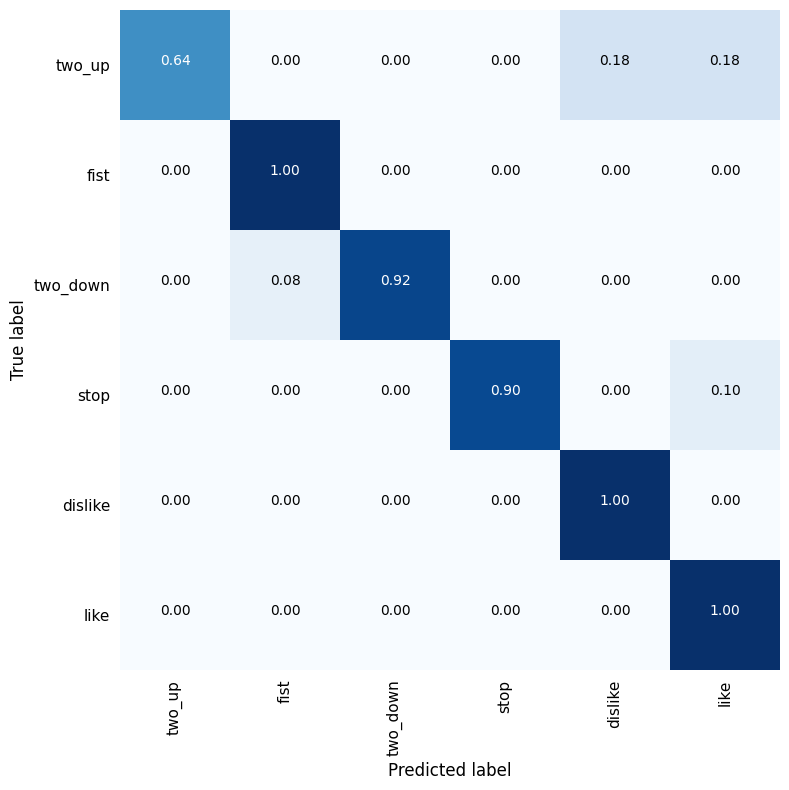

In [51]:
y_pred = y_pred.astype(int)
y_test_num = np.vectorize(gesture_to_num.get)(y_test) # convert string labels in integers

print("\nClassification Report:")
print(classification_report(y_test_num, y_pred, target_names=gestures, labels=np.array([i for i in range(len(gestures))]), digits=4, zero_division=0))


print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_pred : s_preds.append(gestures[el])
for el in y_test_num : s_targets.append(gestures[el])

cm = [np.zeros([len(gestures)]) for _ in range(len(gestures))]
cm += confusion_matrix(s_targets, s_preds, labels=gestures)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, gestures)

In [ ]:
torch.save(best_model.state_dict(), 'MLP_nonull.pth')

!cp MLP_nonull.pth /content/drive/My\ Drive/ColabData/MLP_nonull.pth

#### Following models are for completeness
They haven't been deployed in the final application either because of lower performance or because they reached same performance but with much more complex architectures.

#### 1D CONV

In [ ]:
class Gest1Dconv(nn.Module): # works similar to MLP
  def __init__(self):
    super(Gest1Dconv, self).__init__()
    self.flatten = nn.Flatten()
    self.conv1 = nn.Conv1d(3, 16, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)

    self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

    self.fc1 = nn.Linear(128, 56)
    self.fc2 = nn.Linear(56, 6)

    self.dropout = nn.Dropout(0.5)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = x.permute(0,2,1)
    x = self.pool(self.relu(self.conv1(x)))
    x = self.pool(self.relu(self.conv2(x)))
    x = self.pool(self.relu(self.conv3(x)))
    x = self.flatten(x)
    x = self.dropout(self.relu(self.fc1(x)))
    x = self.fc2(x)
    return x

In [ ]:
# Define training parameters
torch.manual_seed(42)
torch.cuda.manual_seed(42)
num_folds = 8
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True)
epochs = 1000

# Initialize lists to store evaluation metrics
best_model = []
best_accuracy = 0.0
best_results = []

# Loop through each fold
for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train)):
  print(f'Fold {fold_idx+1}/{num_folds}')

  # Split data into training and validation sets for this fold
  data_train = LandmarksDataset(X_train[train_idx], y_train[train_idx], gesture_to_num)
  data_val = LandmarksDataset(X_train[val_idx], y_train[val_idx], gesture_to_num)

  dataloader_train= DataLoader(data_train, batch_size = 24, shuffle = True)
  dataloader_val= DataLoader(data_val, batch_size = 24, shuffle = False)

  model = Gest1Dconv().to(device)

  loss_fn = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  model_results = train(model=model, train_dataloader = dataloader_train,
                        val_dataloader = dataloader_val, optimizer = optimizer,
                        loss_fn = loss_fn, epochs = epochs)

  if model_results['val_acc'][-1] > best_accuracy:
    best_model = model
    best_accuracy = model_results['val_acc'][-1]
    best_results = model_results

Fold 1/8
Epoch: 0 | Train loss: 1.7920 | Train acc: 0.18  | Validation loss: 1.7855 | Validation acc: 0.20
Epoch: 200 | Train loss: 0.5289 | Train acc: 0.79  | Validation loss: 0.6064 | Validation acc: 0.83
Early stopping at epoch: 400
Fold 2/8
Epoch: 0 | Train loss: 1.7950 | Train acc: 0.17  | Validation loss: 1.7882 | Validation acc: 0.18
Epoch: 200 | Train loss: 0.4406 | Train acc: 0.84  | Validation loss: 0.5255 | Validation acc: 0.73
Early stopping at epoch: 345
Fold 3/8
Epoch: 0 | Train loss: 1.7955 | Train acc: 0.17  | Validation loss: 1.7901 | Validation acc: 0.14
Epoch: 200 | Train loss: 0.3929 | Train acc: 0.84  | Validation loss: 0.8577 | Validation acc: 0.86
Early stopping at epoch: 209
Fold 4/8
Epoch: 0 | Train loss: 1.7955 | Train acc: 0.17  | Validation loss: 1.7920 | Validation acc: 0.16
Epoch: 200 | Train loss: 0.4766 | Train acc: 0.83  | Validation loss: 0.4672 | Validation acc: 0.81
Epoch: 400 | Train loss: 0.3309 | Train acc: 0.86  | Validation loss: 0.4850 | Valida

In [ ]:
# Test on the held out set
data_test = LandmarksDataset(X_test, y_test, gesture_to_num)
dataloader_test= DataLoader(data_test, batch_size = 24, shuffle = False)
test_loss, test_acc, y_pred = val_step(model = best_model,
                              data_loader=dataloader_test,
                              loss_fn = loss_fn,
                              device = device)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

Test Loss: 0.30730465054512024, Test Accuracy: 0.9027777777777778


In [ ]:
torch.save(best_model.state_dict(), '1Dconv_nonull.pth')

!cp 1Dconv_nonull.pth /content/drive/My\ Drive/ColabData/1Dconv_nonull.pth


Classification Report:
              precision    recall  f1-score   support

      two_up     1.0000    0.6364    0.7778        11
        fist     1.0000    0.8333    0.9091         6
    two_down     1.0000    0.9167    0.9565        12
        stop     1.0000    0.9000    0.9474        10
     dislike     0.4615    1.0000    0.6316         6
        like     1.0000    1.0000    1.0000         7

    accuracy                         0.8654        52
   macro avg     0.9103    0.8811    0.8704        52
weighted avg     0.9379    0.8654    0.8798        52


Confusion Matrix:


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

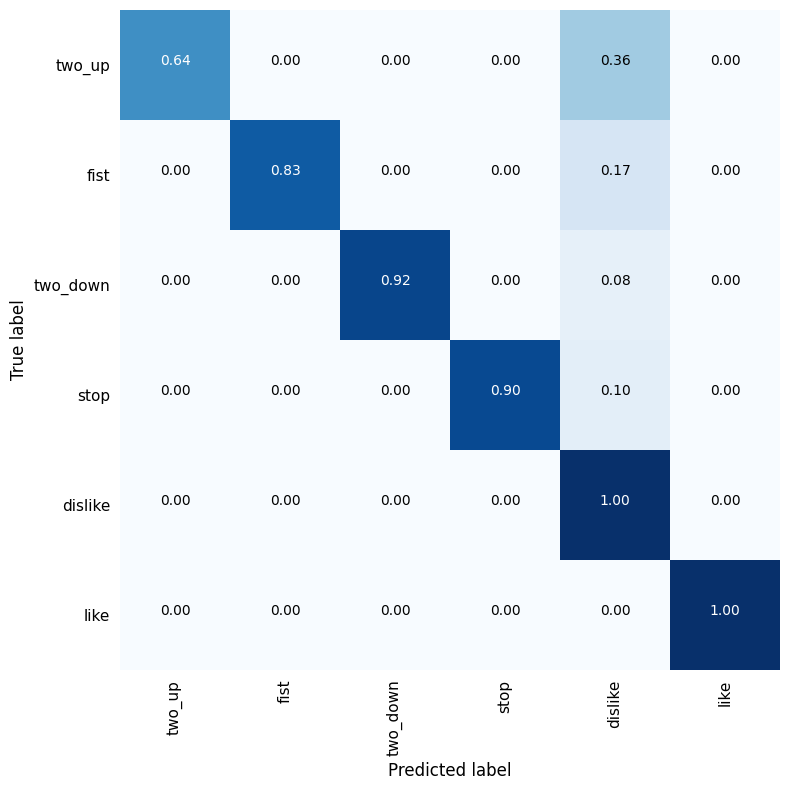

In [ ]:
y_pred = y_pred.astype(int)
y_test_num = np.vectorize(gesture_to_num.get)(y_test) # convert string labels in integers

print("\nClassification Report:")
print(classification_report(y_test_num, y_pred, target_names=gestures, labels=np.array([i for i in range(len(gestures))]), digits=4, zero_division=0))


print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_pred : s_preds.append(gestures[el])
for el in y_test_num : s_targets.append(gestures[el])

cm = [np.zeros([len(gestures)]) for _ in range(len(gestures))]
cm += confusion_matrix(s_targets, s_preds, labels=gestures)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, gestures)

#### LSTM

In [ ]:
class GestLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(GestLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.relu(out[:, -1, :])
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = GestLSTM(input_size = 3, hidden_size = 128, num_layers = 2, num_classes = 6).to(device)
print(model)

GestLSTM(
  (lstm): LSTM(3, 128, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=6, bias=True)
  (relu): ReLU()
)


In [ ]:
# Define training parameters
torch.manual_seed(42)
torch.cuda.manual_seed(42)
num_folds = 8
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True)
epochs = 1000

# Initialize lists to store evaluation metrics
best_model = []
best_accuracy = 0.0
best_results = []

# Loop through each fold
for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train)):
  print(f'Fold {fold_idx+1}/{num_folds}')

  # Split data into training and validation sets for this fold
  data_train = LandmarksDataset(X_train[train_idx], y_train[train_idx], gesture_to_num)
  data_val = LandmarksDataset(X_train[val_idx], y_train[val_idx], gesture_to_num)

  dataloader_train= DataLoader(data_train, batch_size = 24, shuffle = True)
  dataloader_val= DataLoader(data_val, batch_size = 24, shuffle = False)

  model = GestLSTM(input_size = 3, hidden_size = 128, num_layers = 2, num_classes = 6).to(device)

  loss_fn = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  model_results = train(model=model, train_dataloader = dataloader_train,
                        val_dataloader = dataloader_val, optimizer = optimizer,
                        loss_fn = loss_fn, epochs = epochs)

  if model_results['val_acc'][-1] > best_accuracy:
    best_model = model
    best_accuracy = model_results['val_acc'][-1]
    best_results = model_results

Fold 1/8
Epoch: 0 | Train loss: 1.7946 | Train acc: 0.17  | Validation loss: 1.7881 | Validation acc: 0.18
Epoch: 200 | Train loss: 0.4092 | Train acc: 0.83  | Validation loss: 0.4983 | Validation acc: 0.76
Epoch: 400 | Train loss: 0.1435 | Train acc: 0.94  | Validation loss: 0.2801 | Validation acc: 0.91
Early stopping at epoch: 444
Fold 2/8
Epoch: 0 | Train loss: 1.7934 | Train acc: 0.17  | Validation loss: 1.7943 | Validation acc: 0.14
Epoch: 200 | Train loss: 0.2754 | Train acc: 0.88  | Validation loss: 0.3850 | Validation acc: 0.92
Early stopping at epoch: 248
Fold 3/8
Epoch: 0 | Train loss: 1.7930 | Train acc: 0.16  | Validation loss: 1.7876 | Validation acc: 0.21
Early stopping at epoch: 144
Fold 4/8
Epoch: 0 | Train loss: 1.7941 | Train acc: 0.17  | Validation loss: 1.7893 | Validation acc: 0.20
Epoch: 200 | Train loss: 0.2579 | Train acc: 0.89  | Validation loss: 0.3353 | Validation acc: 0.86
Early stopping at epoch: 295
Fold 5/8
Epoch: 0 | Train loss: 1.7957 | Train acc: 0.17

In [ ]:
# Test on the held out set
data_test = LandmarksDataset(X_test, y_test, gesture_to_num)
dataloader_test= DataLoader(data_test, batch_size = 24, shuffle = False)
test_loss, test_acc, y_pred = val_step(model = best_model,
                              data_loader=dataloader_test,
                              loss_fn = loss_fn,
                              device = device)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

Test Loss: 0.7133690118789673, Test Accuracy: 0.8333333333333334


In [ ]:
torch.save(best_model.state_dict(), 'LSTM_nonull.pth')

!cp LSTM_nonull.pth /content/drive/My\ Drive/ColabData/LSTM_nonull.pth


Classification Report:
              precision    recall  f1-score   support

      two_up     1.0000    0.6364    0.7778        11
        fist     0.6250    0.8333    0.7143         6
    two_down     0.8000    0.6667    0.7273        12
        stop     0.8182    0.9000    0.8571        10
     dislike     0.7500    1.0000    0.8571         6
        like     0.6250    0.7143    0.6667         7

    accuracy                         0.7692        52
   macro avg     0.7697    0.7918    0.7667        52
weighted avg     0.7963    0.7692    0.7683        52


Confusion Matrix:


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

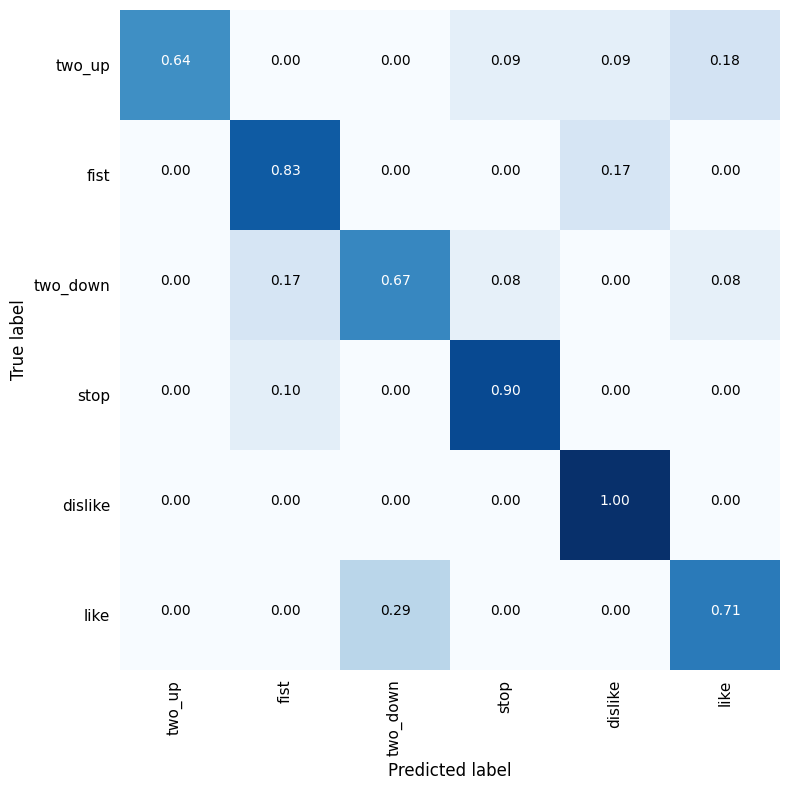

In [ ]:
y_pred = y_pred.astype(int)
y_test_num = np.vectorize(gesture_to_num.get)(y_test) # convert string labels in integers

print("\nClassification Report:")
print(classification_report(y_test_num, y_pred, target_names=gestures, labels=np.array([i for i in range(len(gestures))]), digits=4, zero_division=0))


print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_pred : s_preds.append(gestures[el])
for el in y_test_num : s_targets.append(gestures[el])

cm = [np.zeros([len(gestures)]) for _ in range(len(gestures))]
cm += confusion_matrix(s_targets, s_preds, labels=gestures)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, gestures)

#### SVM & XGBoost

A trial with "classic" classifier to see the improvement given by NN deployment for this problem.

In [ ]:
# let's load landmarks and labels
landmarks_path = '/content/drive/My Drive/ColabData/landmarks_oh.npy'
landmarks = np.load(landmarks_path)
labels_path = '/content/drive/My Drive/ColabData/labels_oh.npy'
labels = np.load(labels_path)

In [ ]:
# remove class(es) we won't use
landmarks =landmarks[labels != 'None']
labels = labels[labels != 'None']
landmarks =landmarks[labels != 'peace']
labels = labels[labels != 'peace']

In [ ]:
landmarks = landmarks.reshape(512,-1)
labels= np.vectorize(gesture_to_num.get)(labels) # convert string labels in integers

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(landmarks, labels, test_size=0.1, random_state=42)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [ ]:
# Define training parameters
num_folds = 5
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True)
epochs = 1000

# Initialize lists to store evaluation metrics
best_model = []
best_accuracy = 0.0
accuracies = []

# Loop through each fold
for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train)):
  print(f'Fold {fold_idx+1}/{num_folds}')

  # Split data into training and validation sets for this fold
  X_tr, X_val = X_train[train_idx], X_train[val_idx]
  y_tr, y_val = y_train[train_idx], y_train[val_idx]

  svm_classifier = SVC(kernel='linear')
  svm_classifier.fit(X_train, y_train)

  accuracy = accuracy_score(y_test, svm_classifier.predict(X_test))
  print(f'Validation Accuracy: {accuracy}')

  if accuracy > best_accuracy:
    best_model = svm_classifier
    best_accuracy = accuracy

  accuracies.append(accuracy)

# Calculate average performance across all folds
avg_accuracy = sum(accuracies) / len(accuracies)

print(f'Average Validation Accuracy: {avg_accuracy}')

Fold 1/5
Validation Accuracy: 0.7115384615384616
Fold 2/5
Validation Accuracy: 0.7115384615384616
Fold 3/5
Validation Accuracy: 0.7115384615384616
Fold 4/5
Validation Accuracy: 0.7115384615384616
Fold 5/5
Validation Accuracy: 0.7115384615384616
Average Validation Accuracy: 0.7115384615384616


In [ ]:
y_pred = best_model.predict(X_test)
test_ccuracy = accuracy_score(y_test, y_test)
print(f'Average Test Accuracy: {avg_accuracy}')

Average Test Accuracy: 0.7115384615384616



Classification Report:
              precision    recall  f1-score   support

      two_up     1.0000    0.5455    0.7059        11
        fist     0.4545    0.8333    0.5882         6
    two_down     1.0000    0.6667    0.8000        12
        stop     1.0000    0.6000    0.7500        10
     dislike     0.4545    0.8333    0.5882         6
        like     0.7000    1.0000    0.8235         7

    accuracy                         0.7115        52
   macro avg     0.7682    0.7465    0.7093        52
weighted avg     0.8337    0.7115    0.7248        52


Confusion Matrix:


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

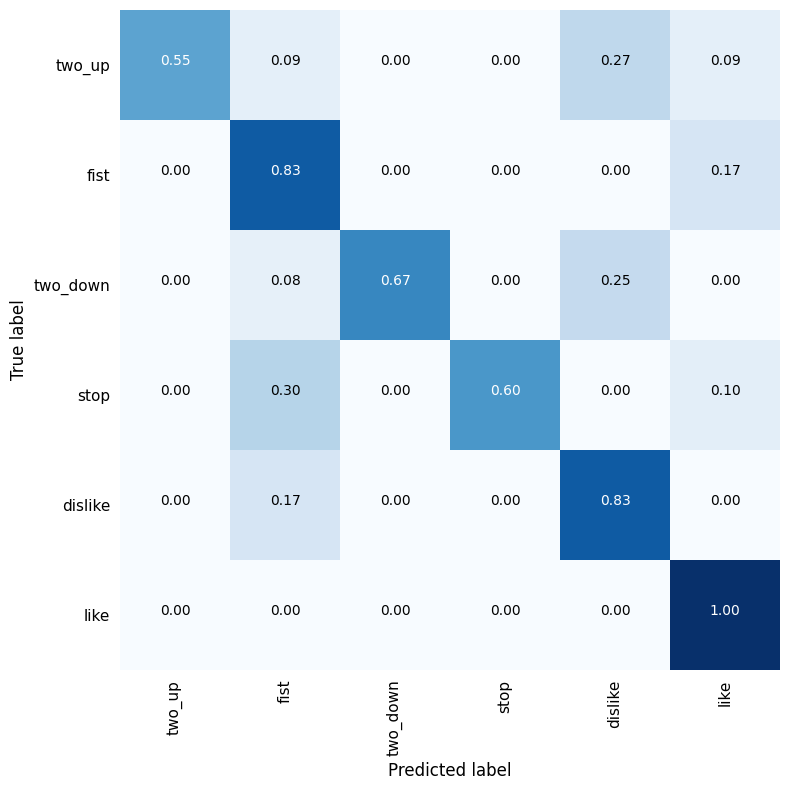

In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=gestures, labels=np.array([i for i in range(len(gestures))]), digits=4, zero_division=0))

#print(classification_report(np.array(y_test_tensor.cpu()), np.array(y_pred.cpu()), target_names=gestures, labels=np.array([i for i in range(len(gestures))]), digits=4, zero_division=0))

print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_pred: s_preds.append(gestures[el])
for el in y_test: s_targets.append(gestures[el])

cm = [np.zeros([len(gestures)]) for _ in range(len(gestures))]
cm += confusion_matrix(s_targets, s_preds, labels=gestures)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, gestures)

In [ ]:
# Define training parameters
num_folds = 5
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True)
epochs = 1000

# Initialize lists to store evaluation metrics
best_model = []
best_accuracy = 0.0
accuracies = []

# Loop through each fold
for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train)):
  print(f'Fold {fold_idx+1}/{num_folds}')

  # Split data into training and validation sets for this fold
  X_tr, X_val = X_train[train_idx], X_train[val_idx]
  y_tr, y_val = y_train[train_idx], y_train[val_idx]

  xgb_classifier = GradientBoostingClassifier()
  xgb_classifier.fit(X_train, y_train)

  accuracy = accuracy_score(y_test, xgb_classifier.predict(X_test))
  print(f'Validation Accuracy: {accuracy}')

  if accuracy > best_accuracy:
    best_model = xgb_classifier
    best_accuracy = accuracy

  accuracies.append(accuracy)

# Calculate average performance across all folds
avg_accuracy = sum(accuracies) / len(accuracies)

print(f'Average Validation Accuracy: {avg_accuracy}')

Fold 1/5
Validation Accuracy: 0.7884615384615384
Fold 2/5
Validation Accuracy: 0.8076923076923077
Fold 3/5
Validation Accuracy: 0.7884615384615384
Fold 4/5
Validation Accuracy: 0.7884615384615384
Fold 5/5
Validation Accuracy: 0.8076923076923077
Average Validation Accuracy: 0.7961538461538462


In [ ]:
y_pred = best_model.predict(X_test)
test_ccuracy = accuracy_score(y_test, y_test)
print(f'Average Test Accuracy: {avg_accuracy}')

Average Test Accuracy: 0.7961538461538462



Classification Report:
              precision    recall  f1-score   support

      two_up     0.8889    0.7273    0.8000        11
        fist     0.7500    1.0000    0.8571         6
    two_down     1.0000    0.7500    0.8571        12
        stop     1.0000    0.8000    0.8889        10
     dislike     0.6000    1.0000    0.7500         6
        like     0.6250    0.7143    0.6667         7

    accuracy                         0.8077        52
   macro avg     0.8106    0.8319    0.8033        52
weighted avg     0.8510    0.8077    0.8132        52


Confusion Matrix:


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

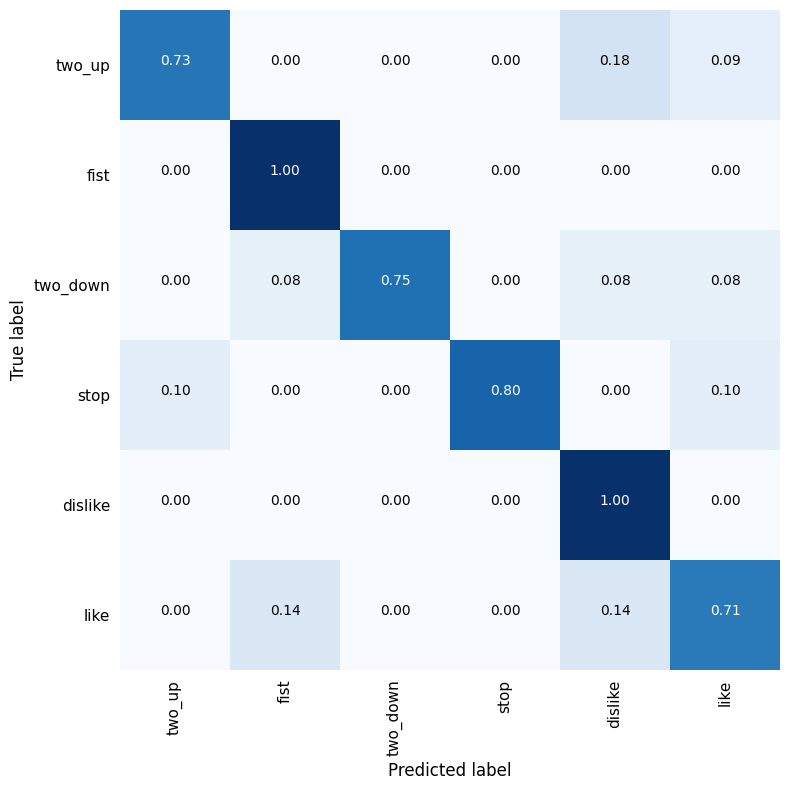

In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=gestures, labels=np.array([i for i in range(len(gestures))]), digits=4, zero_division=0))

#print(classification_report(np.array(y_test_tensor.cpu()), np.array(y_pred.cpu()), target_names=gestures, labels=np.array([i for i in range(len(gestures))]), digits=4, zero_division=0))

print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_pred: s_preds.append(gestures[el])
for el in y_test: s_targets.append(gestures[el])

cm = [np.zeros([len(gestures)]) for _ in range(len(gestures))]
cm += confusion_matrix(s_targets, s_preds, labels=gestures)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, gestures)

##Classifier - w/ null class

This section is here for completeness as we mentioned the possibility of training the classifier with an extra class for random gestures, not in the defined set.

It's structured exactly as the section before.

#### Dataset and DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import needed libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools


In [ ]:
# let's load landmarks and labels
landmarks_path = '/content/drive/My Drive/ColabData/landmarks_roh.npy'
landmarks = np.load(landmarks_path)
labels_path = '/content/drive/My Drive/ColabData/labels_roh.npy'
labels = np.load(labels_path)

In [ ]:
# remove class(es) we won't use
landmarks =landmarks[labels != 'peace']
labels = labels[labels != 'peace']

In [ ]:
# Define gestures and dictionaries gesture <-> number
gestures = ['two_up', 'fist', 'two_down', 'stop', 'dislike', 'like', 'None']
gesture_to_num = {gesture: num for num, gesture in enumerate(gestures)}
num_to_gesture = {num: gesture for gesture, num in gesture_to_num .items()}

In [ ]:
from torch.utils.data import Dataset, DataLoader

class LandmarksDataset(Dataset):
  def __init__(self, landmarks, labels, gesture_to_num):
    self.landmarks = landmarks
    self.labels = labels
    self.gesture_to_num = gesture_to_num

  def __len__(self):
    return len(self.landmarks)

  def __getitem__(self, idx):
    landmark = self.landmarks[idx]
    label = self.gesture_to_num[self.labels[idx]]
    landmark = torch.tensor(landmark, dtype=torch.float32)  # Convert to tensor
    label = torch.tensor(label, dtype=torch.long)  # Convert label to tensor
    return landmark, label

In [ ]:
# split the data in train and test
X_train, X_test, y_train, y_test = train_test_split(landmarks, labels, test_size=0.1, random_state=42)

#### MLP

In [ ]:
class GestClassifier(nn.Module):
  def __init__(self):
    super(GestClassifier, self).__init__()
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(21 * 3, 42)
    self.fc2 = nn.Linear(42, 21)
    self.fc3 = nn.Linear(21, 7)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.flatten(x)
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
# Define training parameters
torch.manual_seed(42)
torch.cuda.manual_seed(42)
num_folds = 8
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True)
epochs = 1000

# Initialize lists to store evaluation metrics
best_model = []
best_accuracy = 0.0
best_results = []

# Loop through each fold
for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train)):
  print(f'Fold {fold_idx+1}/{num_folds}')

  # Split data into training and validation sets for this fold
  data_train = LandmarksDataset(X_train[train_idx], y_train[train_idx], gesture_to_num)
  data_val = LandmarksDataset(X_train[val_idx], y_train[val_idx], gesture_to_num)

  dataloader_train= DataLoader(data_train, batch_size = 24, shuffle = True)
  dataloader_val= DataLoader(data_val, batch_size = 24, shuffle = False)

  model = GestClassifier().to(device)

  loss_fn = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  model_results = train(model=model, train_dataloader = dataloader_train,
                        val_dataloader = dataloader_val, optimizer = optimizer,
                        loss_fn = loss_fn, epochs = epochs)

  if model_results['val_acc'][-1] > best_accuracy:
    best_model = model
    best_accuracy = model_results['val_acc'][-1]
    best_results = model_results

Fold 1/8
Epoch: 0 | Train loss: 1.9436 | Train acc: 0.14  | Validation loss: 1.9326 | Validation acc: 0.18
Early stopping at epoch: 129
Fold 2/8
Epoch: 0 | Train loss: 1.9520 | Train acc: 0.13  | Validation loss: 1.9460 | Validation acc: 0.13
Early stopping at epoch: 128
Fold 3/8
Epoch: 0 | Train loss: 1.9585 | Train acc: 0.13  | Validation loss: 1.9463 | Validation acc: 0.14
Epoch: 200 | Train loss: 0.6910 | Train acc: 0.78  | Validation loss: 0.7002 | Validation acc: 0.71
Epoch: 400 | Train loss: 0.4902 | Train acc: 0.85  | Validation loss: 0.5549 | Validation acc: 0.80
Epoch: 600 | Train loss: 0.3916 | Train acc: 0.87  | Validation loss: 0.5222 | Validation acc: 0.78
Early stopping at epoch: 634
Fold 4/8
Epoch: 0 | Train loss: 1.9493 | Train acc: 0.17  | Validation loss: 1.9417 | Validation acc: 0.17
Epoch: 200 | Train loss: 0.6298 | Train acc: 0.83  | Validation loss: 0.5391 | Validation acc: 0.82
Epoch: 400 | Train loss: 0.4249 | Train acc: 0.86  | Validation loss: 0.3889 | Valida

In [ ]:
# Test on the held out set
data_test = LandmarksDataset(X_test, y_test, gesture_to_num)
dataloader_test= DataLoader(data_test, batch_size = 16, shuffle = False)
test_loss, test_acc, y_pred = val_step(model = best_model,
                              data_loader=dataloader_test,
                              loss_fn = loss_fn,
                              device = device)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

Test Loss: 0.429998517036438, Test Accuracy: 0.8385416666666666



Classification Report:
              precision    recall  f1-score   support

      two_up     1.0000    0.5833    0.7368        12
        fist     1.0000    0.7000    0.8235        10
    two_down     1.0000    1.0000    1.0000        11
        stop     1.0000    0.7500    0.8571         4
     dislike     0.8571    1.0000    0.9231         6
        like     0.6316    1.0000    0.7742        12
        None     0.6667    0.8000    0.7273         5

    accuracy                         0.8333        60
   macro avg     0.8793    0.8333    0.8346        60
weighted avg     0.8843    0.8333    0.8329        60


Confusion Matrix:


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

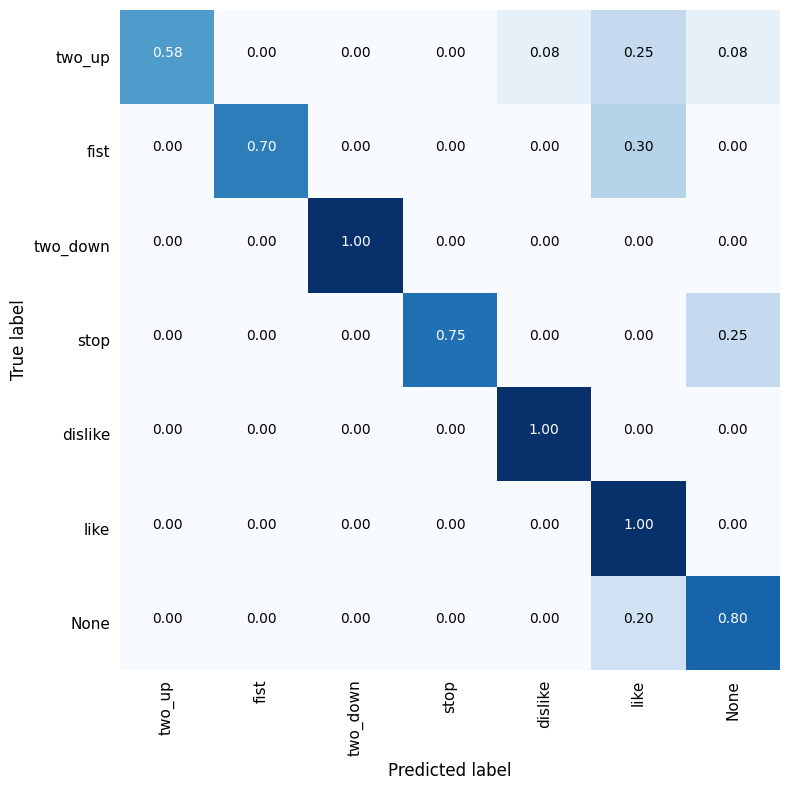

In [ ]:
y_pred = y_pred.astype(int)
y_test_num = np.vectorize(gesture_to_num.get)(y_test) # convert string labels in integers

print("\nClassification Report:")
print(classification_report(y_test_num, y_pred, target_names=gestures, labels=np.array([i for i in range(len(gestures))]), digits=4, zero_division=0))


print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_pred : s_preds.append(gestures[el])
for el in y_test_num : s_targets.append(gestures[el])

cm = [np.zeros([len(gestures)]) for _ in range(len(gestures))]
cm += confusion_matrix(s_targets, s_preds, labels=gestures)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, gestures)

In [ ]:
torch.save(best_model.state_dict(), 'MLP_batch24.pth')

!cp MLP_batch24.pth /content/drive/My\ Drive/ColabData/MLP_batch24.pth

#### 1D CONV

In [ ]:
class Gest1Dconv(nn.Module): # works similar to MLP
  def __init__(self):
    super(Gest1Dconv, self).__init__()
    self.flatten = nn.Flatten()
    self.conv1 = nn.Conv1d(3, 16, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)

    self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

    self.fc1 = nn.Linear(128, 56)
    self.fc2 = nn.Linear(56, 7)

    self.dropout = nn.Dropout(0.5)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = x.permute(0,2,1)
    x = self.pool(self.relu(self.conv1(x)))
    x = self.pool(self.relu(self.conv2(x)))
    x = self.pool(self.relu(self.conv3(x)))
    x = self.flatten(x)
    x = self.dropout(self.relu(self.fc1(x)))
    x = self.fc2(x)
    return x

In [ ]:
# Define training parameters
torch.manual_seed(42)
torch.cuda.manual_seed(42)
num_folds = 8
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True)
epochs = 1000

# Initialize lists to store evaluation metrics
best_model = []
best_accuracy = 0.0
best_results = []

# Loop through each fold
for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train)):
  print(f'Fold {fold_idx+1}/{num_folds}')

  # Split data into training and validation sets for this fold
  data_train = LandmarksDataset(X_train[train_idx], y_train[train_idx], gesture_to_num)
  data_val = LandmarksDataset(X_train[val_idx], y_train[val_idx], gesture_to_num)

  dataloader_train= DataLoader(data_train, batch_size = 24, shuffle = True)
  dataloader_val= DataLoader(data_val, batch_size = 24, shuffle = False)

  model = Gest1Dconv().to(device)

  loss_fn = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  model_results = train(model=model, train_dataloader = dataloader_train,
                        val_dataloader = dataloader_val, optimizer = optimizer,
                        loss_fn = loss_fn, epochs = epochs)

  if model_results['val_acc'][-1] > best_accuracy:
    best_model = model
    best_accuracy = model_results['val_acc'][-1]
    best_results = model_results

Fold 1/8
Epoch: 0 | Train loss: 1.9470 | Train acc: 0.16  | Validation loss: 1.9451 | Validation acc: 0.21
Early stopping at epoch: 143
Fold 2/8
Epoch: 0 | Train loss: 1.9509 | Train acc: 0.14  | Validation loss: 1.9478 | Validation acc: 0.14
Epoch: 200 | Train loss: 0.5250 | Train acc: 0.81  | Validation loss: 0.7035 | Validation acc: 0.69
Early stopping at epoch: 231
Fold 3/8
Epoch: 0 | Train loss: 1.9459 | Train acc: 0.16  | Validation loss: 1.9437 | Validation acc: 0.15
Epoch: 200 | Train loss: 0.5556 | Train acc: 0.80  | Validation loss: 0.3002 | Validation acc: 0.87
Epoch: 400 | Train loss: 0.3824 | Train acc: 0.85  | Validation loss: 0.2469 | Validation acc: 0.87
Epoch: 600 | Train loss: 0.2863 | Train acc: 0.86  | Validation loss: 0.2210 | Validation acc: 0.89
Epoch: 800 | Train loss: 0.2770 | Train acc: 0.90  | Validation loss: 0.2552 | Validation acc: 0.91
Fold 4/8
Epoch: 0 | Train loss: 1.9464 | Train acc: 0.14  | Validation loss: 1.9421 | Validation acc: 0.15
Epoch: 200 | T

In [ ]:
# Test on the held out set
data_test = LandmarksDataset(X_test, y_test, gesture_to_num)
dataloader_test= DataLoader(data_test, batch_size = 24, shuffle = False)
test_loss, test_acc, y_pred = val_step(model = best_model,
                              data_loader=dataloader_test,
                              loss_fn = loss_fn,
                              device = device)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

Test Loss: 0.4247550368309021, Test Accuracy: 0.8472222222222222


In [ ]:
torch.save(best_model.state_dict(), '1dconv.pth')

!cp 1dconv.pth /content/drive/My\ Drive/ColabData/1dconv.pth


Classification Report:
              precision    recall  f1-score   support

      two_up     0.8000    0.6667    0.7273        12
        fist     1.0000    0.7000    0.8235        10
    two_down     1.0000    1.0000    1.0000        11
        stop     0.8000    1.0000    0.8889         4
     dislike     1.0000    0.8333    0.9091         6
        like     0.6111    0.9167    0.7333        12
        None     1.0000    0.8000    0.8889         5

    accuracy                         0.8333        60
   macro avg     0.8873    0.8452    0.8530        60
weighted avg     0.8689    0.8333    0.8370        60


Confusion Matrix:


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

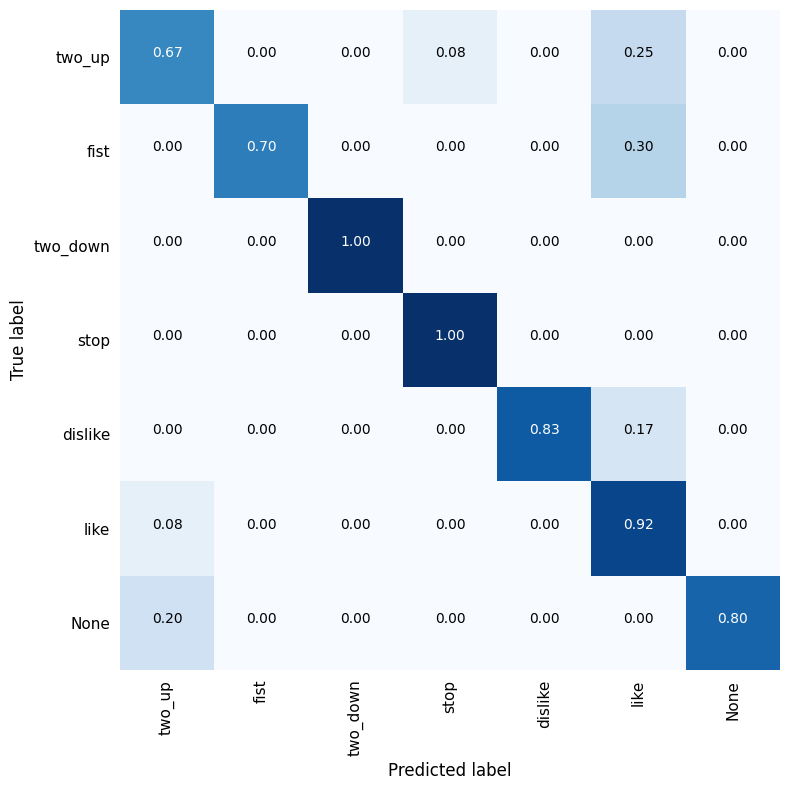

In [ ]:
y_pred = y_pred.astype(int)
y_test_num = np.vectorize(gesture_to_num.get)(y_test) # convert string labels in integers

print("\nClassification Report:")
print(classification_report(y_test_num, y_pred, target_names=gestures, labels=np.array([i for i in range(len(gestures))]), digits=4, zero_division=0))


print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_pred : s_preds.append(gestures[el])
for el in y_test_num : s_targets.append(gestures[el])

cm = [np.zeros([len(gestures)]) for _ in range(len(gestures))]
cm += confusion_matrix(s_targets, s_preds, labels=gestures)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, gestures)

#### SVM & XGBoost

In [ ]:
landmarks = landmarks.reshape(598,-1)
labels= np.vectorize(gesture_to_num.get)(labels) # convert string labels in integers

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(landmarks, labels, test_size=0.1, random_state=42)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [ ]:
# Define training parameters
num_folds = 5
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True)
epochs = 1000

# Initialize lists to store evaluation metrics
best_model = []
best_accuracy = 0.0
accuracies = []

# Loop through each fold
for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train)):
  print(f'Fold {fold_idx+1}/{num_folds}')

  # Split data into training and validation sets for this fold
  X_tr, X_val = X_train[train_idx], X_train[val_idx]
  y_tr, y_val = y_train[train_idx], y_train[val_idx]

  svm_classifier = SVC(kernel='linear')
  svm_classifier.fit(X_train, y_train)

  accuracy = accuracy_score(y_test, svm_classifier.predict(X_test))
  print(f'Validation Accuracy: {accuracy}')

  if accuracy > best_accuracy:
    best_model = svm_classifier
    best_accuracy = accuracy

  accuracies.append(accuracy)

# Calculate average performance across all folds
avg_accuracy = sum(accuracies) / len(accuracies)

print(f'Average Validation Accuracy: {avg_accuracy}')

Fold 1/5
Validation Accuracy: 0.8
Fold 2/5
Validation Accuracy: 0.8
Fold 3/5
Validation Accuracy: 0.8
Fold 4/5
Validation Accuracy: 0.8
Fold 5/5
Validation Accuracy: 0.8
Average Validation Accuracy: 0.8


In [ ]:
y_pred = best_model.predict(X_test)
test_ccuracy = accuracy_score(y_test, y_test)
print(f'Average Test Accuracy: {avg_accuracy}')

Average Test Accuracy: 0.8



Classification Report:
              precision    recall  f1-score   support

      two_up     1.0000    0.5833    0.7368        12
        fist     0.8750    0.7000    0.7778        10
    two_down     1.0000    1.0000    1.0000        11
        stop     1.0000    0.7500    0.8571         4
     dislike     0.7143    0.8333    0.7692         6
        like     0.6111    0.9167    0.7333        12
        None     0.6667    0.8000    0.7273         5

    accuracy                         0.8000        60
   macro avg     0.8382    0.7976    0.8002        60
weighted avg     0.8450    0.8000    0.8017        60


Confusion Matrix:


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

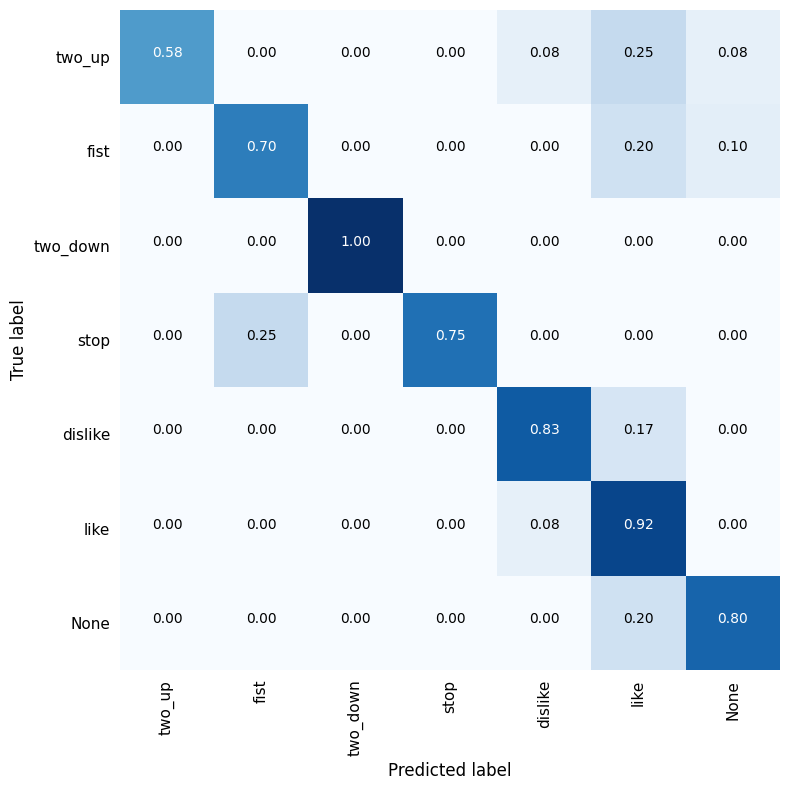

In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=gestures, labels=np.array([i for i in range(len(gestures))]), digits=4, zero_division=0))

#print(classification_report(np.array(y_test_tensor.cpu()), np.array(y_pred.cpu()), target_names=gestures, labels=np.array([i for i in range(len(gestures))]), digits=4, zero_division=0))

print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_pred: s_preds.append(gestures[el])
for el in y_test: s_targets.append(gestures[el])

cm = [np.zeros([len(gestures)]) for _ in range(len(gestures))]
cm += confusion_matrix(s_targets, s_preds, labels=gestures)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, gestures)

In [ ]:
# Define training parameters
num_folds = 5
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True)
epochs = 1000

# Initialize lists to store evaluation metrics
best_model = []
best_accuracy = 0.0
accuracies = []

# Loop through each fold
for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train)):
  print(f'Fold {fold_idx+1}/{num_folds}')

  # Split data into training and validation sets for this fold
  X_tr, X_val = X_train[train_idx], X_train[val_idx]
  y_tr, y_val = y_train[train_idx], y_train[val_idx]

  xgb_classifier = GradientBoostingClassifier()
  xgb_classifier.fit(X_train, y_train)

  accuracy = accuracy_score(y_test, xgb_classifier.predict(X_test))
  print(f'Validation Accuracy: {accuracy}')

  if accuracy > best_accuracy:
    best_model = xgb_classifier
    best_accuracy = accuracy

  accuracies.append(accuracy)

# Calculate average performance across all folds
avg_accuracy = sum(accuracies) / len(accuracies)

print(f'Average Validation Accuracy: {avg_accuracy}')

Fold 1/5
Validation Accuracy: 0.7833333333333333
Fold 2/5
Validation Accuracy: 0.8
Fold 3/5
Validation Accuracy: 0.8
Fold 4/5
Validation Accuracy: 0.8
Fold 5/5
Validation Accuracy: 0.7833333333333333
Average Validation Accuracy: 0.7933333333333333


In [ ]:
y_pred = best_model.predict(X_test)
test_ccuracy = accuracy_score(y_test, y_test)
print(f'Average Test Accuracy: {avg_accuracy}')

Average Test Accuracy: 0.7933333333333333



Classification Report:
              precision    recall  f1-score   support

      two_up     0.8000    0.6667    0.7273        12
        fist     1.0000    0.8000    0.8889        10
    two_down     1.0000    1.0000    1.0000        11
        stop     1.0000    0.7500    0.8571         4
     dislike     0.4444    0.6667    0.5333         6
        like     0.7692    0.8333    0.8000        12
        None     0.6667    0.8000    0.7273         5

    accuracy                         0.8000        60
   macro avg     0.8115    0.7881    0.7906        60
weighted avg     0.8305    0.8000    0.8080        60


Confusion Matrix:


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

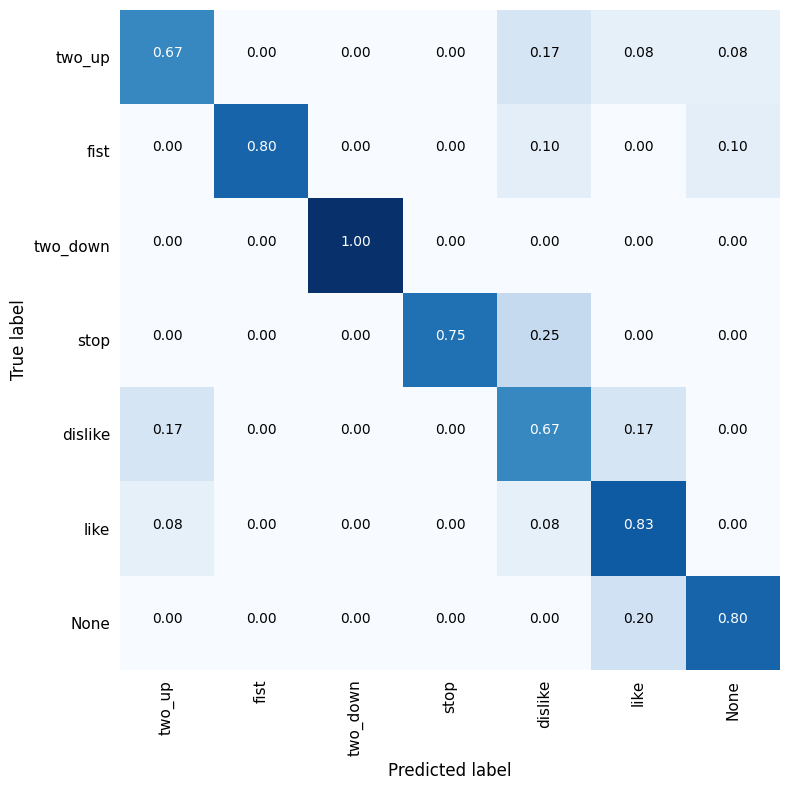

In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=gestures, labels=np.array([i for i in range(len(gestures))]), digits=4, zero_division=0))

#print(classification_report(np.array(y_test_tensor.cpu()), np.array(y_pred.cpu()), target_names=gestures, labels=np.array([i for i in range(len(gestures))]), digits=4, zero_division=0))

print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_pred: s_preds.append(gestures[el])
for el in y_test: s_targets.append(gestures[el])

cm = [np.zeros([len(gestures)]) for _ in range(len(gestures))]
cm += confusion_matrix(s_targets, s_preds, labels=gestures)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, gestures)

#### LSTM

In [ ]:
class GestLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(GestLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.relu(out[:, -1, :])
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = GestLSTM(input_size = 3, hidden_size = 128, num_layers = 2, num_classes = 7).to(device)
print(model)

GestLSTM(
  (lstm): LSTM(3, 128, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=7, bias=True)
  (relu): ReLU()
)


In [ ]:
# Define training parameters
torch.manual_seed(42)
torch.cuda.manual_seed(42)
num_folds = 8
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True)
epochs = 1000

# Initialize lists to store evaluation metrics
best_model = []
best_accuracy = 0.0
best_results = []

# Loop through each fold
for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train)):
  print(f'Fold {fold_idx+1}/{num_folds}')

  # Split data into training and validation sets for this fold
  data_train = LandmarksDataset(X_train[train_idx], y_train[train_idx], gesture_to_num)
  data_val = LandmarksDataset(X_train[val_idx], y_train[val_idx], gesture_to_num)

  dataloader_train= DataLoader(data_train, batch_size = 24, shuffle = True)
  dataloader_val= DataLoader(data_val, batch_size = 24, shuffle = False)

  model = GestLSTM(input_size = 3, hidden_size = 128, num_layers = 2, num_classes = 7).to(device)

  loss_fn = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  model_results = train(model=model, train_dataloader = dataloader_train,
                        val_dataloader = dataloader_val, optimizer = optimizer,
                        loss_fn = loss_fn, epochs = epochs)

  if model_results['val_acc'][-1] > best_accuracy:
    best_model = model
    best_accuracy = model_results['val_acc'][-1]
    best_results = model_results

Fold 1/8
Epoch: 0 | Train loss: 1.9468 | Train acc: 0.14  | Validation loss: 1.9432 | Validation acc: 0.15
Epoch: 200 | Train loss: 0.3395 | Train acc: 0.88  | Validation loss: 0.5640 | Validation acc: 0.81
Early stopping at epoch: 243
Fold 2/8
Epoch: 0 | Train loss: 1.9500 | Train acc: 0.13  | Validation loss: 1.9467 | Validation acc: 0.13
Epoch: 200 | Train loss: 0.4485 | Train acc: 0.82  | Validation loss: 0.5858 | Validation acc: 0.84
Early stopping at epoch: 308
Fold 3/8
Epoch: 0 | Train loss: 1.9455 | Train acc: 0.14  | Validation loss: 1.9433 | Validation acc: 0.16
Epoch: 200 | Train loss: 1.5747 | Train acc: 0.31  | Validation loss: 1.6288 | Validation acc: 0.29
Early stopping at epoch: 342
Fold 4/8
Epoch: 0 | Train loss: 1.9478 | Train acc: 0.15  | Validation loss: 1.9454 | Validation acc: 0.15
Epoch: 200 | Train loss: 1.6740 | Train acc: 0.30  | Validation loss: 1.7599 | Validation acc: 0.23
Early stopping at epoch: 326
Fold 5/8
Epoch: 0 | Train loss: 1.9507 | Train acc: 0.11

In [ ]:
# Test on the held out set
data_test = LandmarksDataset(X_test, y_test, gesture_to_num)
dataloader_test= DataLoader(data_test, batch_size = 24, shuffle = False)
test_loss, test_acc, y_pred = val_step(model = best_model,
                              data_loader=dataloader_test,
                              loss_fn = loss_fn,
                              device = device)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

Test Loss: 0.5786224603652954, Test Accuracy: 0.8055555555555557


In [ ]:
torch.save(best_model.state_dict(), 'LSTMmodel.pth')

!cp LSTMmodel.pth /content/drive/My\ Drive/ColabData/LSTMmodel.pth


Classification Report:
              precision    recall  f1-score   support

      two_up     0.7778    0.5833    0.6667        12
        fist     1.0000    0.6000    0.7500        10
    two_down     0.9167    1.0000    0.9565        11
        stop     1.0000    0.7500    0.8571         4
     dislike     0.5455    1.0000    0.7059         6
        like     0.7857    0.9167    0.8462        12
        None     0.8000    0.8000    0.8000         5

    accuracy                         0.8000        60
   macro avg     0.8322    0.8071    0.7975        60
weighted avg     0.8353    0.8000    0.7973        60


Confusion Matrix:


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

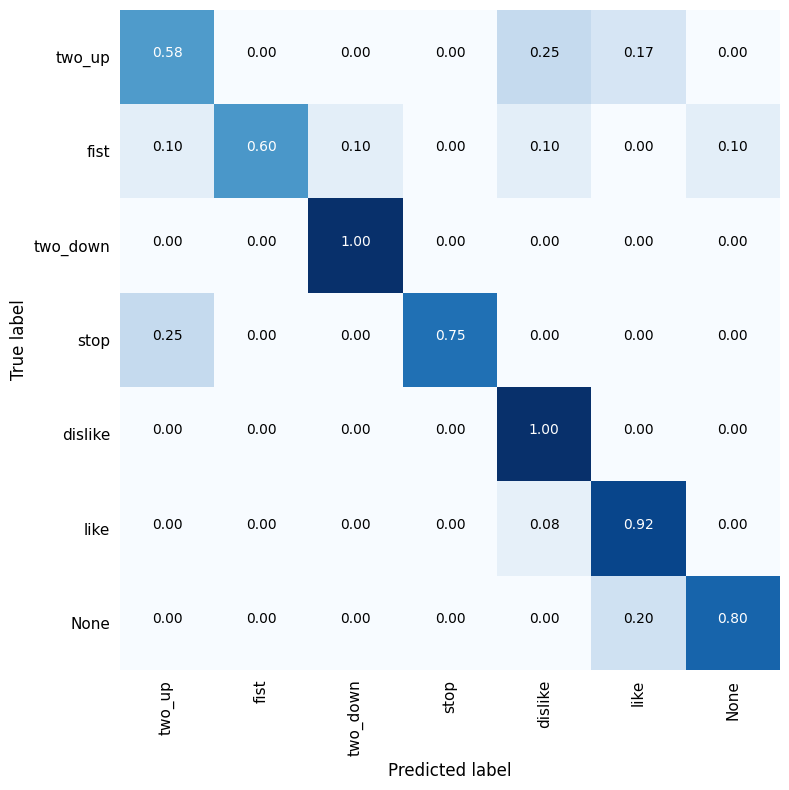

In [ ]:
y_pred = y_pred.astype(int)
y_test_num = np.vectorize(gesture_to_num.get)(y_test) # convert string labels in integers

print("\nClassification Report:")
print(classification_report(y_test_num, y_pred, target_names=gestures, labels=np.array([i for i in range(len(gestures))]), digits=4, zero_division=0))


print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_pred : s_preds.append(gestures[el])
for el in y_test_num : s_targets.append(gestures[el])

cm = [np.zeros([len(gestures)]) for _ in range(len(gestures))]
cm += confusion_matrix(s_targets, s_preds, labels=gestures)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, gestures)